In [1]:
#load images
from sklearn.metrics import log_loss
import os
import numpy as np
import csv
#from scipy.misc import imresize
from skimage.transform import resize
from keras.preprocessing import image
#from keras.utils import np_utils
from keras.utils import to_categorical
import cv2
import tensorflow as tf

img_width, img_height = 224, 224
nb_classes=2
train_data_dir='ISBI2016/train'
validation_data_dir='ISBI2016/test'


# Load Data
def load_data(data_type):
    '''Load and resize data'''
    print ('Loading data: ', data_type)
    if data_type == 'train':
        data_dir = train_data_dir
        print ('Loading train data... ')
    else:
        data_dir = validation_data_dir
        print ('Loading test data... ')

    # assume malignant = 0, benign = 1
    malignant_path = os.path.join(data_dir, 'malignant')
    malignant_list = os.listdir(malignant_path)  # get a list of all malignant image files in directory
    malignant_num = len(malignant_list)
    benign_path = os.path.join(data_dir, 'benign')
    benign_list = os.listdir(benign_path)
    benign_num = len(benign_list)

    X = np.empty((benign_num + malignant_num, img_width, img_height,3 ), dtype='float32')
    y = np.zeros((benign_num + malignant_num, ), dtype='uint8')
    
    for i, benign_file in enumerate(benign_list):
        #img1 = image.load_img(os.path.join(benign_path, benign_file), grayscale=False)
        #img1 = image.load_img(os.path.join(benign_path, benign_file), grayscale=False)
        img = tf.keras.utils.load_img(os.path.join(benign_path, benign_file),color_mode="rgb",target_size=(224, 224),interpolation="bicubic")
        #img = imresize(img1,(img_width, img_height),interp='bicubic')
        #img = resize(img1, (img_width, img_height))
        #img = resize(img1, (224, 224,3))
        #img = cv2.resize(img1, (224, 224))
        arr= image.img_to_array(img)
        X[i] =arr
        y[i] = 0

    # store the malignant
    for i, malignant_file in enumerate(malignant_list):
        #img1 = image.load_img(os.path.join(malignant_path, malignant_file), grayscale=False)
        img = tf.keras.utils.load_img(os.path.join(malignant_path, malignant_file),color_mode="rgb",target_size=(224, 224),interpolation="bicubic")
        #img = imresize(img1,(img_width, img_height),interp='bicubic')
        #img = resize(img1, (img_width, img_height))
        #img = resize(img1, (224, 224,3))
        #img = cv2.resize(img1, (224, 224))
        arr= image.img_to_array(img)
        X[i+benign_num] = arr
        y[i+benign_num]=1
    # add the benign and set flag to 1 (this should be equal to "1D binary labels" as in the example flow_from_directory)
    return X, y

In [2]:
import pandas as pd
import shutil
from zipfile import ZipFile
import requests
from zipfile import ZipFile
import pandas as pd
import os
import shutil
import sys
#!pip install imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import cv2
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
train_images_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip"
test_images_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip"
train_gt_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv"
test_gt_url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv"

In [ ]:
a = requests.get(train_images_url, allow_redirects=True)
b = requests.get(test_images_url, allow_redirects=True)
c = requests.get(train_gt_url, allow_redirects=True)
d = requests.get(test_gt_url, allow_redirects=True)

In [ ]:
open('ISBI2016_ISIC_Part3_Training_Data.zip', 'wb').write(a.content)
open('ISBI2016_ISIC_Part3_Test_Data.zip', 'wb').write(b.content)
open('ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 'wb').write(c.content)
open('ISBI2016_ISIC_Part3_Test_GroundTruth.csv', 'wb').write(d.content)

In [ ]:
train_dataset = 'ISBI2016_ISIC_Part3_Test_Data.zip'
test_dataset = 'ISBI2016_ISIC_Part3_Training_Data.zip'
with ZipFile(train_dataset,'r') as zip:
  zip.extractall()
  print('The train dataset is extracted')
with ZipFile(test_dataset,'r') as zip:
  zip.extractall()
  print('The test dataset is extracted')

In [3]:
train_df = pd.read_csv('ISBI2016_ISIC_Part3_Training_GroundTruth.csv',names=["Image Name", "Label"])
test_df = pd.read_csv('ISBI2016_ISIC_Part3_Test_GroundTruth.csv',names=["Image Name", "Label"])

In [3]:
os.makedirs("ISBI2016/train/benign")
os.makedirs("ISBI2016/test/benign")
os.mkdir('./ISBI2016/test/malignant')
os.mkdir('./ISBI2016/train/malignant')

#20_16_ISBI/train/benign
#20_16_ISBI/train/malignant

In [4]:
def Make_Dir_train(src, dst, Data):
    Labels = Data[['Image Name','Label']]
    for imagename, label in Labels.values:
        src_path = src + '/'+ imagename + '.jpg'
        if(label == 'benign'):
            dst_path = dst + '/' + 'benign'
        else:
            dst_path = dst + '/' + 'malignant'
        shutil.copy(src_path, dst_path)

In [5]:
def Make_Dir_test(src, dst, Data):
    Labels = Data[['Image Name','Label']]
    for imagename, label in Labels.values:
        src_path = src + '/'+ imagename + '.jpg'
        if(label == 0):
            dst_path = dst + '/' + 'benign'
        else:
            dst_path = dst + '/' + 'malignant'
        shutil.copy(src_path, dst_path)

In [8]:
Make_Dir_train('ISBI2016_ISIC_Part3_Training_Data','ISBI2016/train', train_df)

In [9]:
Make_Dir_test('ISBI2016_ISIC_Part3_Test_Data','ISBI2016/test', test_df)

In [4]:
##img_width, img_height = 224, 224
#nb_classes=2
#train_data_dir='ISBI2016/train'
#validation_data_dir='ISBI2016/test'
X_train, Y_train = load_data('train')
X_test, Y_test = load_data('test')

Loading data:  train
Loading train data... 
Loading data:  test
Loading test data... 


In [5]:
Y_train = to_categorical(Y_train, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)

In [6]:
# if random data is required
idx = np.random.permutation(len(X_train))
X_train,Y_train = X_train[idx], Y_train[idx]

idx = np.random.permutation(len(X_test))
X_test,Y_test = X_test[idx], Y_test[idx]

In [7]:
TRAIN_SIZE= X_train.shape[0]
X_tr=np.empty((TRAIN_SIZE, img_width, img_height, 3), dtype='float32')
TEST_SIZE= X_test.shape[0]
X_te=np.empty((TEST_SIZE, img_width, img_height, 3), dtype='float32')
from numpy import *
# compute per image mean and subtract each pixel 
for i in range (TRAIN_SIZE):
    x=X_train[i]
    x-=np.mean(x, axis=(0, 1))
    X_tr[i]=x
    
for i in range (TEST_SIZE):
    x=X_test[i]
    x-=np.mean(x, axis=(0, 1))
    X_te[i]=x
X_test=X_te
X_train=X_tr

In [79]:
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.models import Model
#from keras.preprocessing import image
#from keras.layers import Flatten, Input

#base_model = VGG16(weights='imagenet')
#model = Model(input=base_model.input, outputs=base_model.get_layer('fc1').output)
#image_size = (224, 224, 3)

#from keras.applications.resnet50 import ResNet50
#from keras.models import Model
#from keras.preprocessing import image
#from keras.layers import Flatten, Input
#from keras.applications.resnet50 import preprocess_input

#model = ResNet50(weights='imagenet')
#ResNet_model = Model(inputs=model.input, outputs=(model.layers[-3].output) )

from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Flatten, Input, Dense
from keras.applications.resnet50 import preprocess_input

base_model = ResNet50(weights='imagenet', pooling=max, include_top = False)
input = Input(shape=(224,224,3),name = 'image_input')
x = base_model(input)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(2, activation='sigmoid')(x)
model = Model(inputs=input, outputs=x)

In [80]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              #optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

In [81]:
# training the neural network
history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=2)

Epoch 1/2
 3/23 [==>...........................] - ETA: 8:16 - loss: 4.9070 - accuracy: 0.6771

KeyboardInterrupt: 

In [75]:
weights = model. get_layer('dense_1'). get_weights()

In [76]:
weights

[array([[ 3.3899616e-03,  5.9618964e-03,  5.1599792e-03, ...,
          6.7893281e-03, -2.9713241e-03,  7.4453079e-03],
        [ 4.0449570e-03,  4.4397102e-03, -6.4299828e-03, ...,
          2.6860763e-03, -4.8585702e-05, -3.3478569e-03],
        [-5.7185018e-03, -2.0558201e-04, -4.8716543e-03, ...,
         -1.4712117e-03,  1.0141404e-04, -3.0552037e-06],
        ...,
        [-6.9619063e-03,  1.8480378e-03,  2.5951234e-03, ...,
         -6.9639138e-03,  6.3209762e-03, -5.7031130e-03],
        [-1.4838753e-03, -2.4817903e-03, -7.8425882e-04, ...,
         -3.5283468e-03, -6.4963456e-03, -2.8713024e-03],
        [-3.7503687e-03, -1.7375192e-03, -8.4266486e-04, ...,
          5.7532219e-04, -7.4187014e-03,  7.2833872e-03]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [73]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 2048)              205522944 
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 229112705 (874.00 MB)
Trainable params: 229059585 (873.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________

In [31]:
X_train[0].shape

(224, 224, 3)

In [32]:
TRAIN_SIZE

900

In [33]:
train_features=np.empty((TRAIN_SIZE, 2048), dtype='float32')
train_features.shape

(900, 2048)

In [34]:
x = image.img_to_array(X_train[0])
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [35]:
features = model.predict(x)
features.shape

1/1 [==============================] - 1s 1s/step


(1, 2048)

In [36]:
features_reduce =  features.squeeze()
features_reduce.shape

(2048,)

In [37]:
feature_shape = 2048

In [38]:
# extract the training and testing features

#train_features=np.empty((TRAIN_SIZE, 2048), dtype='float32')
train_features=np.empty((TRAIN_SIZE, feature_shape), dtype='float32')
print("loading training features")
for i in range (TRAIN_SIZE):
    x = image.img_to_array(X_train[i])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    features_reduce =  features.squeeze()
    
    train_features[i]=features_reduce

loading training features
1/1 [==============================] - 0s 260ms/step


In [39]:

#test_features=np.empty((TEST_SIZE, 2048), dtype='float32')
test_features=np.empty((TEST_SIZE, feature_shape), dtype='float32')

print("loading testing features")
for i in range (TEST_SIZE):
    x = image.img_to_array(X_test[i])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    features_reduce =  features.squeeze() 
    test_features[i]=features_reduce

loading testing features
1/1 [==============================] - 0s 250ms/step


In [40]:
# to compute the mean of the features columnwise
size=len(train_features[1,:])
mean_vectors_train = []
for cl in range(2):
    print(cl)
    mean_vectors_train.append(np.mean(train_features[np.argmax(Y_train,1)==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors_train[cl]))
print(mean_vectors_train[0].shape)
print(mean_vectors_train[1].shape)

0
Mean Vector class 0: [0.16034093 0.5384992  0.48678792 ... 0.05096935 0.08778664 1.736973  ]

1
Mean Vector class 1: [0.19049917 0.5104403  0.32054934 ... 0.02667829 0.05968065 1.3639797 ]

(2048,)
(2048,)


In [43]:
# within class scatter matrix
size=len(train_features[1,:])
S_W_train = np.zeros((size,size))
y=np.argmax(Y_train,1)
for cl,mv in zip(range(2), mean_vectors_train):
    class_sc_mat = np.zeros((size,size))                  # scatter matrix for every class
    for row in train_features[y== cl]:
        row, mv = row.reshape(size,1), mv.reshape(size,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W_train += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W_train)
print(S_W_train.shape)

within-class Scatter Matrix:
 [[ 1.46222464e+02 -5.11310608e+00  2.32625209e+01 ...  4.74397315e-01
  -4.77913535e+00  6.71135020e-01]
 [-5.11310608e+00  5.07925137e+02  2.69152899e+01 ... -9.42556976e+00
  -1.24102921e+01 -1.74141885e+01]
 [ 2.32625209e+01  2.69152899e+01  7.73902110e+02 ... -8.65850916e+00
   2.76951147e+00  3.48316632e+01]
 ...
 [ 4.74397315e-01 -9.42556976e+00 -8.65850916e+00 ...  4.83048823e+01
   5.13970828e-02 -2.96429423e+01]
 [-4.77913535e+00 -1.24102921e+01  2.76951147e+00 ...  5.13970828e-02
   6.28402149e+01 -1.43728404e+01]
 [ 6.71135020e-01 -1.74141885e+01  3.48316632e+01 ... -2.96429423e+01
  -1.43728404e+01  1.25611519e+03]]
(2048, 2048)


In [44]:
#u,s,v = np.linalg.svd(S_W_train)
#eig_vals=s
#eig_vecs=u


eig_vals,eig_vecs=np.linalg.eig(S_W_train)

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(size,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))
    
    
eig_pairs_lda = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs_lda = sorted(eig_pairs_lda, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs_lda:
    print(i[0])


Eigenvector 1: 
[[-0.00292362]
 [ 0.00572415]
 [ 0.01580278]
 ...
 [ 0.00096081]
 [ 0.0014558 ]
 [ 0.0158699 ]]
Eigenvalue 1: 1.20e+05

Eigenvector 2: 
[[ 0.0077279 ]
 [ 0.00096681]
 [ 0.0334892 ]
 ...
 [-0.00424574]
 [-0.00215762]
 [ 0.04784542]]
Eigenvalue 2: 7.94e+04

Eigenvector 3: 
[[ 0.0023416 ]
 [-0.00216971]
 [ 0.03035388]
 ...
 [ 0.0032099 ]
 [-0.00062849]
 [-0.0002279 ]]
Eigenvalue 3: 6.49e+04

Eigenvector 4: 
[[ 0.00757914]
 [-0.0162002 ]
 [ 0.04589376]
 ...
 [ 0.00204185]
 [ 0.00370729]
 [-0.02841982]]
Eigenvalue 4: 4.56e+04

Eigenvector 5: 
[[ 0.00516481]
 [ 0.00646404]
 [-0.03703829]
 ...
 [-0.00269095]
 [-0.00796605]
 [ 0.04031234]]
Eigenvalue 5: 3.26e+04

Eigenvector 6: 
[[-2.59763010e-03]
 [-1.37357197e-02]
 [-5.26348868e-02]
 ...
 [ 6.46621515e-03]
 [-5.08878326e-05]
 [ 3.48830053e-02]]
Eigenvalue 6: 2.86e+04

Eigenvector 7: 
[[ 0.00882595]
 [ 0.01587975]
 [ 0.00455347]
 ...
 [ 0.00114738]
 [-0.00263445]
 [ 0.00715656]]
Eigenvalue 7: 2.28e+04

Eigenvector 8: 
[[ 2.39

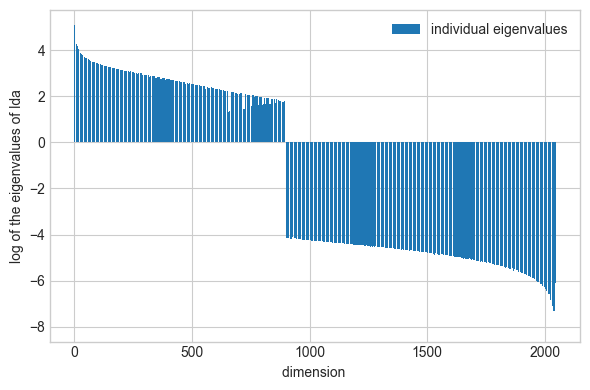

In [45]:
# to plot the eigen values
import matplotlib.pyplot as plt
import math
size=len(eig_vals)
x_plot=np.empty(size,dtype='float32')
for i in range (size):
    x_plot[i]=math.log10(np.abs(eig_vals[i]))
#y_axis=np.transpose(np.abs(eig_vals))
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6,4))
    plt.bar(range(2048), x_plot, alpha=1, align='center',
            label='individual eigenvalues')
    plt.ylabel('log of the eigenvalues of lda')
    plt.xlabel('dimension ')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [46]:
# to compute the variance of the eigenvalues
print('Variance explained:\n')
eigv_sum = sum(np.abs(eig_vals))
for i,j in enumerate(eig_pairs_lda):
    print(j[0])
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

120489.99009022966
eigenvalue 1: 8.54%
79392.27755963228
eigenvalue 2: 5.63%
64879.5764893904
eigenvalue 3: 4.60%
45623.448458178565
eigenvalue 4: 3.24%
32626.645806201217
eigenvalue 5: 2.31%
28572.743237596114
eigenvalue 6: 2.03%
22764.716925689438
eigenvalue 7: 1.61%
21371.1537350812
eigenvalue 8: 1.52%
19794.970581662554
eigenvalue 9: 1.40%
17847.50596081174
eigenvalue 10: 1.27%
16808.73130066449
eigenvalue 11: 1.19%
15791.95547604664
eigenvalue 12: 1.12%
14778.786463324932
eigenvalue 13: 1.05%
14253.771130597928
eigenvalue 14: 1.01%
13553.721614705291
eigenvalue 15: 0.96%
13308.289402215814
eigenvalue 16: 0.94%
11687.853000246772
eigenvalue 17: 0.83%
11355.52032876397
eigenvalue 18: 0.81%
10223.388450859533
eigenvalue 19: 0.73%
10055.963060545471
eigenvalue 20: 0.71%
9691.299568036275
eigenvalue 21: 0.69%
9222.859634493232
eigenvalue 22: 0.65%
8905.75643076126
eigenvalue 23: 0.63%
8268.38636052689
eigenvalue 24: 0.59%
8114.696076733948
eigenvalue 25: 0.58%
7849

In [47]:
# select the non-zeros eigenvalues
count =0
size=len(train_features[1,:])
for i in eig_pairs_lda:
    if(i[0]<10e-5):
        count+=1
print(count)
non_zero_lda=size-count
print(non_zero_lda)

1151
897


In [48]:
#case2: selection of the remaining eigenvectors and dividing with the minimum eigenvalue
size=len(train_features[1,:])
div=math.sqrt(np.abs(eig_vals[non_zero_lda-1]))
#Wsw2=np.empty((size,size-non_zero_lda), dtype=float)
Wsw2=[]
k=0
for i in range (non_zero_lda,size):
    x=eig_pairs_lda[i][1].reshape(size,1)
    g=x.real//div
    Wsw2.append(g)

W=Wsw2
print(div)
print(len(Wsw2))
print(Wsw2[0].shape)

8.516044998683343
1151
(2048, 1)


In [49]:
# case1: selection of eigen vector corresponding to nonzeros eigenvalues 
# and dividing by the corresponding eigen values
size=len(train_features[1,:])
#Wsw1=np.zeros((size,non_zero_lda), dtype=float)
Wsw1=[]
k=0
for i in range (non_zero_lda):
    div=math.sqrt(np.abs(eig_vals[i]))
    x=eig_pairs_lda[i][1].reshape(size,1) 
    l=x.real//div
    Wsw1.append(l)
    
W=Wsw1
print(W[0].shape)

(2048, 1)


In [50]:
# case3: merging of case1 and case2
import math
# for case1
size=len(train_features[1,:])
Wsw1=[]
k=0
for i in range (non_zero_lda):
    div=math.sqrt(np.abs(eig_vals[i]))
    x=eig_pairs_lda[i][1].reshape(size,1) 
    l=x.real//div
    Wsw1.append(l)
#print(Wsw[1][0:200])
#print('Matrix W:\n', W.real)

div=math.sqrt(np.abs(eig_vals[non_zero_lda-1]))
#Wsw2=np.empty((size,size-non_zero_lda), dtype=float)
Wsw2=[]
k=0
for i in range (non_zero_lda,size):
    x=eig_pairs_lda[i][1].reshape(size,1)
    g=x.real//div
    Wsw2.append(g)

#W=np.concatenate((Wsw1,Wsw2), axis=1)
#W = np.column_stack((Wsw1,Wsw2))
W = Wsw1+Wsw2
print(len(W))

2048


In [51]:
# projecting of training features onto this W matrix
X_lda = train_features.dot(W)
print(X_lda.shape)
#assert X_lda.shape == (TRAIN_SIZE,size-non_zero)

(900, 2048, 1)


In [52]:
# computation of covariance matrix for PCA 
data=np.squeeze(X_lda)
data=np.transpose(data)
cov_mat=np.cov(data)
#mean_vec = np.mean(data, axis=0)
#cov_mat = (data - mean_vec).dot((data - mean_vec).T) / (data.shape[0]-1)
print("covariance matrix shape", cov_mat.shape)
#u,s,v = np.linalg.svd(cov_mat)
#eig_val_cov=s
#eig_vec_cov=u

eig_val_cov,eig_vec_cov=np.linalg.eig(cov_mat)
print("eigenvector size",eig_vec_cov.shape)
print("eigen_values",eig_val_cov.shape)

covariance matrix shape (2048, 2048)
eigenvector size (2048, 2048)
eigen_values (2048,)


In [53]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs_pca = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs_pca = sorted(eig_pairs_pca, key=lambda k: k[0], reverse=True)


# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs_pca:
    print(i[0])

39973268.4855131
47020.48712241664
38950.02111822351
22584.77046519634
16685.92331422636
14708.229954310615
11998.600355473101
11061.67807566866
10136.920271200039
9828.838050434077
8875.472837475145
8106.363351959628
7732.977034105689
7390.105928939241
7023.757358111526
6959.738421551955
6489.560141651061
5962.564799657678
5525.682855947173
5291.12406000665
5060.463540052426
5007.231631868263
4789.982169470918
4387.01943865787
4315.033779896222
4238.400412071472
4083.714201229198
4004.7972980518734
3884.6355406880157
3732.27296710477
3698.6369247223033
3517.3520501176185
3493.276810911155
3384.152187013031
3328.52307158187
3238.6379906954076
3217.8126618861183
3091.3750861422695
3052.6648150506544
3020.707950481984
2983.7049927411636
2926.2490198791897
2831.175343045273
2822.5977501766033
2732.09261898098
2695.158812444406
2638.5270355311977
2591.3941756500003
2556.9382706763563
2549.018995511876
2487.6537570364976
2480.844716244233
2413.21481770182
2392.5225497457604
2344.39006854348

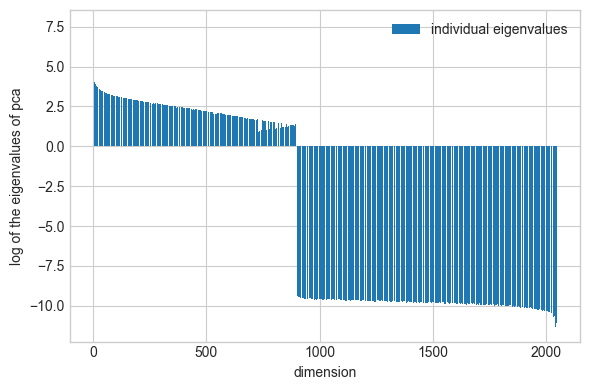

In [54]:
# plot the PCA eigen values
import matplotlib.pyplot as plt
import math

size=len(eig_val_cov)
x_plot=np.zeros(size,dtype=float)
for i in range (size):
    x_plot[i]=math.log10(np.abs(eig_val_cov[i]))
#print(x_plot.shape)

#y_axis=np.transpose(np.abs(eig_val_cov))
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6,4))

    plt.bar(range(size), x_plot, alpha=1, align='center',
            label='individual eigenvalues')
    plt.ylabel('log of the eigenvalues of pca')
    plt.xlabel('dimension')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [55]:
# variances of the PCA eigen values
print('Variance explained:\n')
eigv_sum = sum(np.abs(eig_val_cov))
for i,j in enumerate(eig_pairs_pca):
    print(j[0])
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

39973268.4855131
eigenvalue 1: 98.31%
47020.48712241664
eigenvalue 2: 0.12%
38950.02111822351
eigenvalue 3: 0.10%
22584.77046519634
eigenvalue 4: 0.06%
16685.92331422636
eigenvalue 5: 0.04%
14708.229954310615
eigenvalue 6: 0.04%
11998.600355473101
eigenvalue 7: 0.03%
11061.67807566866
eigenvalue 8: 0.03%
10136.920271200039
eigenvalue 9: 0.02%
9828.838050434077
eigenvalue 10: 0.02%
8875.472837475145
eigenvalue 11: 0.02%
8106.363351959628
eigenvalue 12: 0.02%
7732.977034105689
eigenvalue 13: 0.02%
7390.105928939241
eigenvalue 14: 0.02%
7023.757358111526
eigenvalue 15: 0.02%
6959.738421551955
eigenvalue 16: 0.02%
6489.560141651061
eigenvalue 17: 0.02%
5962.564799657678
eigenvalue 18: 0.01%
5525.682855947173
eigenvalue 19: 0.01%
5291.12406000665
eigenvalue 20: 0.01%
5060.463540052426
eigenvalue 21: 0.01%
5007.231631868263
eigenvalue 22: 0.01%
4789.982169470918
eigenvalue 23: 0.01%
4387.01943865787
eigenvalue 24: 0.01%
4315.033779896222
eigenvalue 25: 0.01%
4238.4004120

In [56]:
# to calculate the number of non-zero eigen values
count =0
size_eig_vec_cov=len(eig_vec_cov[:,1])
for i in (eig_pairs_pca):
    if(i[0]<10e-2):
        count+=1
non_zero_pca=size_eig_vec_cov-count
print(non_zero_pca)

898


In [57]:
# selection of the eigen vector correponding to the non-zero eigen values
size1=len(eig_vec_cov[1,:])
matrix_wpca=np.zeros((size1, non_zero_pca), dtype='float32')
for i in range (non_zero_pca):
    x=eig_pairs_pca[i][1]
    matrix_wpca[:,i]=x.real
print(matrix_wpca.shape)
#print('Matrix W:\n', matrix_w.real)
wpca=np.transpose(matrix_wpca)
print(wpca.shape)

(2048, 898)
(898, 2048)


In [58]:
# final W matrix
W=np.squeeze(W)
final_W=wpca.dot(W)
print(final_W.shape)

(898, 2048)


In [59]:
#projection of testing images onto this final_W
test_projection = test_features.dot(final_W.T)
print(test_projection.shape)

(379, 898)


In [60]:
#projection of testing images onto this final_W
train_projection = train_features.dot(final_W.T)
print(train_projection.shape)

(900, 898)


In [61]:
from sklearn import svm
clf=svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf.fit(train_projection, np.argmax(Y_train,1))

accuracy = clf.score(test_projection, np.argmax(Y_test,1))
print("ACC=", accuracy)
preds=clf.predict(test_projection)
print(preds)
print(np.argmax(Y_test,1))

ACC= 0.7203166226912929
[0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0
 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1
 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0
 1 1 1 0 0 0 0 0 0]
[0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1

In [62]:
# OR using LinearSVC
from sklearn import svm
labels=np.argmax(Y_train,1)
clf = svm.LinearSVC(C=1.0,random_state=42, loss='hinge')
clf.fit(train_projection, labels)
preds=clf.predict(test_projection)
print(preds)
accuracy = clf.score(test_projection, np.argmax(Y_test,1))
print("ACC=", accuracy)

c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0]
ACC= 0.8126649076517151


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [63]:
def perf_measure(y_actual, y_hat):
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range (len(y_actual)):
        if y_actual[i]==y_hat[i]==1:
            TP=TP+1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP=FP+1 
        if y_actual[i]==y_hat[i]==0:
            TN=TN+1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN=FN+1
    return(TP, FP, TN, FN)

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
TP, FP, TN, FN= perf_measure(np.argmax(Y_test,1), preds)
print(TP,FP,TN,FN)
# Sensitivity, hit rate, recall, or true positive rate
SE = TP/(TP+FN)
# Specificity or true negative rate
SP = TN/(TN+FP) 
PPV=TP/(TP+FP)
NPV=TN/(TN+FN)
acc=(TP+TN)/(TP+FP+TN+FN)
print('accuracy: ', acc)
print('sensitivity: ', SE)
print('specificity: ',SP)

print('positive predictive value: ', PPV)
print('negative predictive value: ',NPV)

print('Average precision = ',average_precision_score(np.argmax(Y_test,1), preds))
print('AUC = ',roc_auc_score(np.argmax(Y_test,1), preds))

9 5 299 66
accuracy:  0.8126649076517151
sensitivity:  0.12
specificity:  0.9835526315789473
positive predictive value:  0.6428571428571429
negative predictive value:  0.8191780821917808
Average precision =  0.25128533735393893
AUC =  0.5517763157894737


In [65]:
p=1
size=len(train_projection[1,:])
print(size)
y_tr=np.argmax(Y_train,1)
y_te=np.argmax(Y_test,1)
acc=np.empty((size//50),dtype='float32')
print(acc.shape)

898
(17,)


In [66]:
for i in range(size//50):
    print(i)
    train=train_projection[:,0:p*50]
    test=test_projection[:,0:p*50]
    clf.fit(train,y_tr)
    accuracy = clf.score(test, y_te)
    acc[i]=accuracy
    p=p+1

0
1


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-pa

2


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


3


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


4


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


5


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


6


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


7


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


8


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


9


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


10


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


11


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


12


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


13


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


14


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


15


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


16


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [67]:
print(acc)

[0.8021108  0.8073879  0.8126649  0.8126649  0.81530344 0.8126649
 0.80474937 0.8021108  0.19788918 0.8100264  0.5488127  0.8100264
 0.8126649  0.6965699  0.8126649  0.8126649  0.8126649 ]


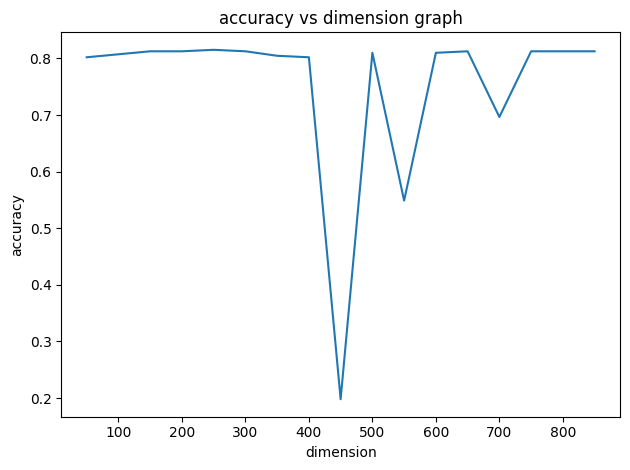

In [68]:
# plot the accuracy vs dimension (50 as the intervals)
import matplotlib.pyplot as plt
y_axis=acc
k=0
x_axis=np.empty(len(acc))
for i in range(50,900,50):
    x_axis[k]=i
    k=k+1

plt.plot(x_axis, y_axis)
plt.ylabel('accuracy')
plt.xlabel('dimension')
plt.title('accuracy vs dimension graph')
#plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [69]:
# final performance matrix wrt the selected number of features

train_final=train_projection[:,0:300]
test_final=test_projection[:,0:300]

clf.fit(train_final,y_tr)
    
accuracy = clf.score(test_final, y_te)
print(accuracy)
preds=clf.predict(test_final)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
TP, FP, TN, FN= perf_measure(np.argmax(Y_test,1), preds)
# Sensitivity, hit rate, recall, or true positive rate
SE = TP/(TP+FN)
# Specificity or true negative rate
SP = TN/(TN+FP) 
PPV=TP/(TP+FP)
NPV=TN/(TN+FN)
print('positive predictive value: ', PPV)
print('negative predictive value: ',NPV)

print('sensitivity: ', SE)
print('specificity: ',SP)
print('Average precision = ',average_precision_score(np.argmax(Y_test,1), preds))
print('AUC = ',roc_auc_score(np.argmax(Y_test,1), preds))

c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8126649076517151
positive predictive value:  1.0
negative predictive value:  0.8106666666666666
sensitivity:  0.05333333333333334
specificity:  1.0
Average precision =  0.24066842568161828
AUC =  0.5266666666666666


c:\Users\Pupul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
